## Unsupervised learning

Другим подходом к обучению представлений являются **автоэнкодеры** — специальный класс нейросетевых архитектур, способный **обучаться на данных без разметки (unsupervised learning)**.

С помощью автоэнкодеров становится возможным обучать представления для данных не имея разметку. Эти представления могут затем использоваться для решения других задач:
* понижение размерности
* очистка данных от шумов
* предобучение для дальнейшего дообучения на размеченных данных
* обнаружение аномалий
* и даже генерация новых данных!

Разницу между двумя **supervised и unsupervised learning** можно понять при помощи илююстрации ниже:

**Supervised learning**

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L12/out/supervised_learning.png" alt="alttext" width="550">

**Unsupervised learning**

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L12/out/unsupervised_learning.png" alt="alttext" width="550">

В случае **supervised learning** для каждого объекта нам известна метка, что вот это — изображение яблок, это — изображение груш и т.&nbsp;д. Далее модель учится по изображению определять фрукт.

В случае же **unsupervised learning** модель просматривает все изображения фруктов, не зная, где какой фрукт находится, и далее формирует представление, которое **неявно** делит фрукты по похожести.



Зачем вообще изучать такой тип задачи?

1. Иногда у нас слишком мало размеченных объектов, чтобы учить на них какую-либо задачу классификации и т. д. При этом у нас огромное количество неразмеченных данных. Мы можем **надеяться**, что если мы как-то обработаем наши данные, то они сами разделятся каким-то образом, согласующимся с метками.

2. Человеческий мозг в основном учится в unsupervised манере. Возможно, для того чтобы решать задачи, которые легко по сравнению с компьютером решает человек, нам стоит и компьютер учить похожим образом.

3. Часто обучение без учителя дает результаты, которые в дальнейшем позволяют быстро адаптироваться к новым задачам обучения с учителем и переключаться между ними. Причем делать это **эффективнее**, чем transfer learning. (*Stop learning tasks, start learning skills* — Satinder Singh).

___

## Сжатие информации и потери

Автоэнкодер может быть без потерь и с потерями (lossless и lossy). В какой-то степени это альтернативно методам сжатия архиваторов и кодирования контента (zip, mp3, jpeg, flac, ...). Можно ли сделать сжатие на нейронных сетях с помощью автоэнкодеров? Да, это будет работать. Размер сети будет большим, но сжатие может превзойти другие алгоритмы. Практический пример — [проект Google Lyra](https://ai.googleblog.com/2021/02/lyra-new-very-low-bitrate-codec-for.html), в котором подобный подход был применен для компрессии звука, и проект [NVIDIA Maxine](https://developer.nvidia.com/maxine), где в свою очередь сжимают видео.


<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L12/out/autoencoder_scheme.png" width="1000">


Почему это может работать? Дело в том, что нейронная сеть может сформулировать набор правил, по которому на основе латентного представления приближенно или точно кодировать (за счет кодировщика), а затем восстанавливать исходный объект (при помощи декодировщика).






<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L12/out/original_space_to_latent_space.png" alt="alttext" width="600">


А почему мы уверены, что такой набор правил будет существовать, и мы вообще имеем право понижать размерность пространства?


___

## Аналогия AE и PCA

Отличия PCA и AE в том, что PCA выполняет линейную комбинацию над компонентами исходного вектора свойств объекта, а AE, как правило, нелинейную. PCA вычисляется однозначно, а AE обучается без гарантии нахождения наилучшего положения. PCA гарантирует ортогональный базис для разложения сжатых свойств, а AE — нет.

PCA будет частным случаем AE, если в AE сделать только **один полносвязный скрытый слой** с количеством нейронов, равным требуемому числу компонент, сделать линейную функцию активации, и использовать среднеквадратическую функцию потерь (MSE). Кроме этого, необходимо будет нормировать признаки перед подачей их на вход AE.



<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L12/out/pca_autoencoder.png" alt="alttext" width="500">



Тогда PCA позволяет рассчитать веса для нейронов такого автоэнкодера. При этом гарантировав (в отличие от градиентного спуска) наилучшее решение задачи.

___

## PCA для избавления от шума

Давайте применим PCA как простейший автоэнкодер для очищения от шумов изображений базы MNIST. Нам потребуется база MNIST, NumPy, библиотека отрисовки matplotlib и сам PCA, который есть в пакете sklearn.

In [1]:
from torchvision.datasets import MNIST
import torchvision
from IPython.display import clear_output

root = "./data"

train_set = MNIST(
    root=root, train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_set = MNIST(
    root=root, train=False, transform=torchvision.transforms.ToTensor(), download=True
)
clear_output()

Загрузим данные и приведём размерность к двумерной, чтобы это был набор векторов свойств.

In [2]:
x_train = train_set.data.numpy()
y_train = train_set.targets.numpy()
x_test = test_set.data.numpy()
y_test = test_set.targets.numpy()

x_train, x_test = x_train / 255.0, x_test / 255.0  # normalize data to [0; 1]
x_train_shape = x_train.shape
print("Initial shape ", x_train_shape)
x_train_flatten = x_train.reshape(x_train_shape[0], -1)  #  reshape to vector, 28*28 => 784
print("Reshaped to ", x_train_flatten.shape)

Initial shape  (60000, 28, 28)
Reshaped to  (60000, 784)


То же самое, но графически:

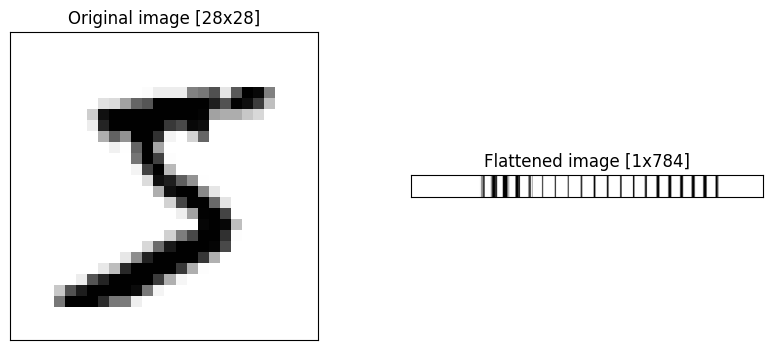

In [3]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
ax[0].imshow(x_train[0], cmap="gray_r")
ax[1].imshow(x_train_flatten[0].reshape(1, -1), aspect=50, cmap="gray_r")
ax[0].set_title("Original image [28x28]")
ax[1].set_title("Flattened image [1x784]")
ax[0].set_xticks([]); ax[0].set_yticks([])
ax[1].set_xticks([]); ax[1].set_yticks([])
plt.show()

Теперь заведём класс PCA и настроим его, чтобы он отобрал столько компонент, чтобы объяснялось 90% дисперсии. Обучим его и посмотрим, сколько ему потребовалось свойств, для описания каждой картинки.

In [4]:
from sklearn.decomposition import PCA

pca = PCA(0.90)
x_train_encoded = pca.fit_transform(x_train_flatten)
print("Encoded features ", pca.n_components_)

Encoded features  87


Энкодер (он же декодер, ведь это просто обратная матрица от энкодера PCA) обучен. Теперь можно проверить, как он закодирует и раскодирует тестовую выборку. Для этого проведём такие же преобразования размерности для неё.

In [5]:
x_test_shape = x_test.shape
x_test_flat = x_test.reshape(x_test_shape[0], -1)
x_test_encoded = pca.transform(x_test_flat)
x_test_decoded = pca.inverse_transform(x_test_encoded).reshape(x_test_shape)
print("x_test_decoded shape is ", x_test_decoded.shape)

x_test_decoded shape is  (10000, 28, 28)


Теперь нужно определить функцию для отрисовки изображений MNIST. Она будет выводить несколько изображений в ряд, поэтому будет принимать трёхмерный массив. Шкала не должна быть автоподстраиваемой, так как после обработки изображения выйдут за диапазон $[0;1]$, в котором заданы исходные изображения. Мы зафиксируем шкалу в диапазоне $[0;1]$.

In [6]:
def plot_imgs(imgs, title):
    fig = plt.figure(figsize=(16, 3))
    columns = imgs.shape[0]
    rows = 1
    for i in range(columns):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(imgs[i], cmap="gray_r", clim=(0, 1))
        plt.xticks([])
        plt.yticks([])
    fig.suptitle(title)
    plt.show()

Выведем исходное и закодированное-раскодированное изображение для некоторых объектов, которые мы случайным образом выберем из всей тестовой выборки.

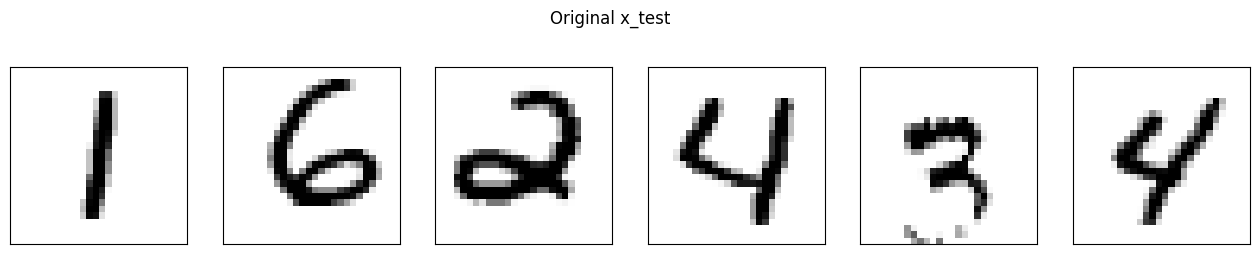

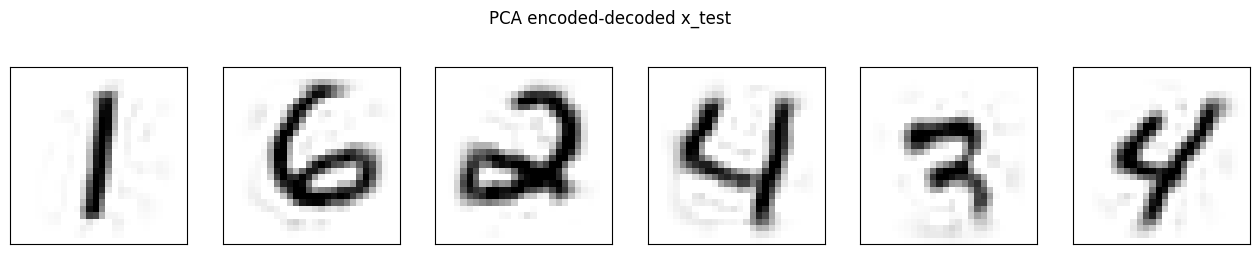

In [7]:
import numpy as np

np.random.seed(42)

sample_indices = np.random.choice(x_test.shape[0], 6)
samples_orig = x_test[sample_indices]
samples_decoded = x_test_decoded[sample_indices]
plot_imgs(samples_orig, "Original x_test")
plot_imgs(samples_decoded, "PCA encoded-decoded x_test")

Видно, что `pca.n_components_` (87 для 90% PCA) достаточно для описания картинок MNIST вместо 784 исходных пикселей. Но при этом нужно хранить матрицу кодирования-декодирования, а изображения получаются немного зашумлёнными. Мы получили способ сжатия с потерями для рукописных цифр, где изображение центрировано и отмасштабировано по рамке из 28х28 пикселей (подробней смотрите правила базы MNIST).

Степень сжатия у нас условно 87/784 ~= 0.11. То есть сжатие в 9 раз. «Условно», так как сжатое изображение хранится во float, а исходное в uint8, который требует в 4 раза меньше байт, плюс мы должны хранить матрицы для кодирования и декодирования.

Теперь посмотрим, как наш автоэнкодер без нейросетей справится с очисткой от зашумления. Для этого сделаем функцию добавления шумов к MNIST и посмотрим результат.

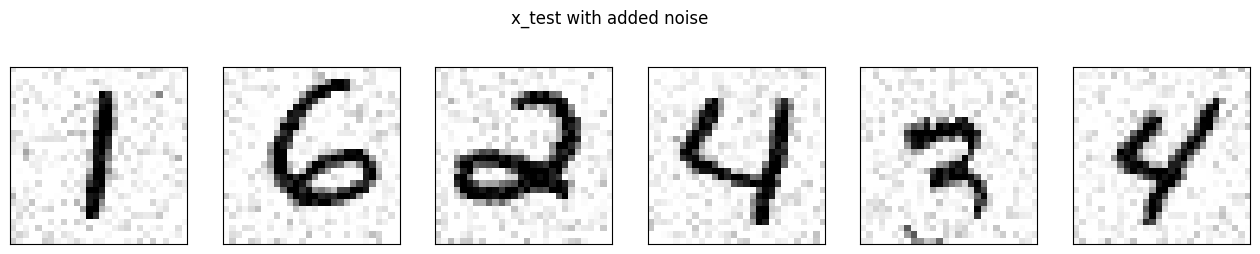

In [8]:
from skimage.util import random_noise

np.random.seed(42)

x_test_noisy = random_noise(x_test, mode="gaussian")
samples_noisy = x_test_noisy[sample_indices]
plot_imgs(samples_noisy, "x_test with added noise")

Теперь нужно провести ту же операцию PCA энкодера и декодера, что выше.

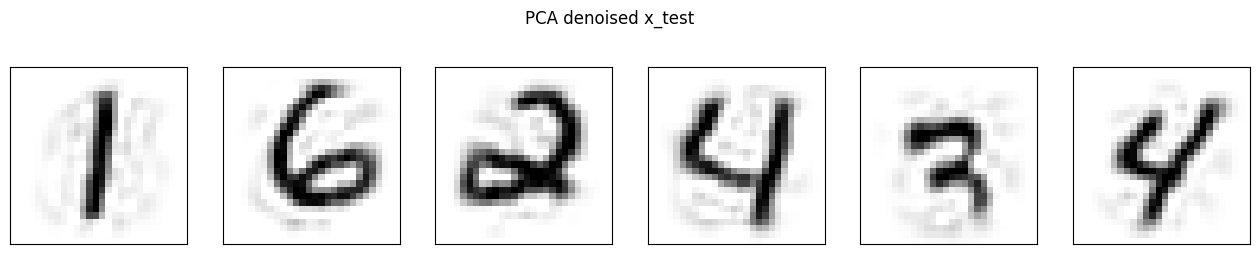

In [9]:
def PCArecode(dataset):
    dataset_flat = dataset.reshape(-1, dataset.shape[1] * dataset.shape[2])
    encoded = pca.transform(dataset_flat)
    decoded = pca.inverse_transform(encoded).reshape(dataset.shape)
    return decoded


x_filtered = PCArecode(x_test_noisy)
samples_filtered = x_filtered[sample_indices]
plot_imgs(samples_filtered, "PCA denoised x_test")

Для простоты сравнения напишем функцию, которая будет строить зашумленные и восстановленные образцы друг под другом.

In [10]:
import numpy as np
import matplotlib.pyplot as plt

def plot_samples(*args, digit_size=28, name=None, single_size=2):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.zeros((digit_size * len(args), digit_size * n))

    for i in range(n):
        for j in range(len(args)):
            figure[
                j * digit_size : (j + 1) * digit_size,
                i * digit_size : (i + 1) * digit_size,
            ] = args[j][i].squeeze()

    plt.figure(figsize=(single_size * n, single_size * len(args)))

    plt.imshow(figure, cmap="gray_r", clim=(0, 1))

    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig(name)
    plt.show()

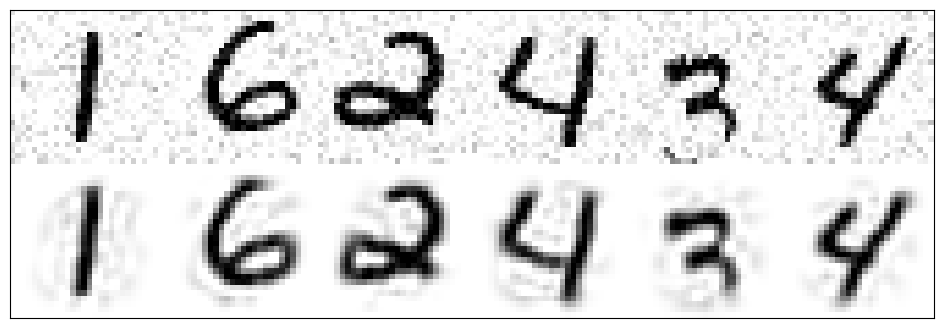

In [11]:
plot_samples(samples_noisy, samples_filtered)

Итак, шумы стали значительно меньше, но и артефакты вокруг цифр усилились. Это неудивительно, ведь мы сжимали информацию линейным образом всего в 87 компонент. Повышение уровня сжатия приведёт к еще большему количеству артефактов.

### Латентное представление цифр после PCA

Посмотрим теперь на то, как разделяются изображения разных цифр в латентном представлении.

In [12]:
def pca_latent(dataset):
    dataset_flat = dataset.reshape(dataset.shape[0], -1)
    return pca.transform(dataset_flat)

In [13]:
def plot_manifold(latent_r, labels=None, alpha=0.9, title=None):
    plt.figure(figsize=(8, 8))
    if labels is None:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], alpha=alpha)
        if title:
            plt.title(title)
    else:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], c=labels, cmap="tab10", alpha=alpha)
        plt.colorbar()
        if title:
            plt.title(title)
    plt.show()

Построим на двумерной плоскости первые две компоненты признаков, выделенных PCA — они объясняют максимум дисперсии исходных признаков.

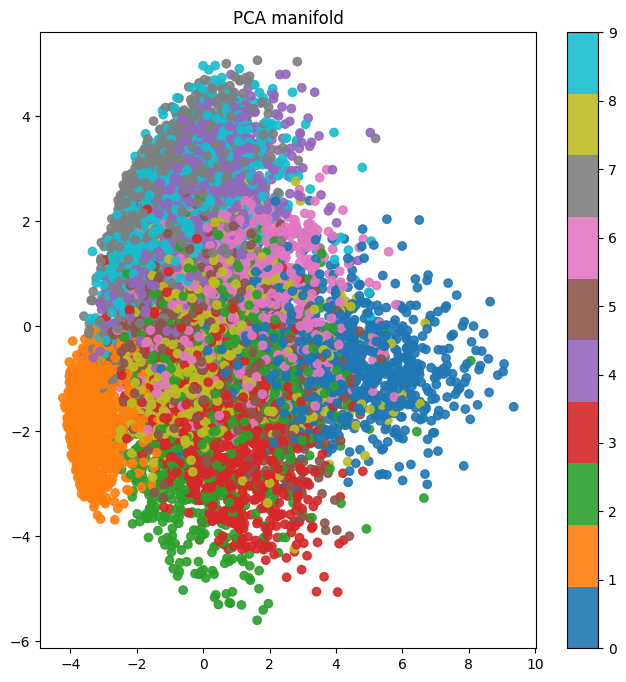

In [14]:
latent_r = pca_latent(x_test)
plot_manifold(latent_r, y_test, title="PCA manifold")

Видим, что латентное представление слабо разделяет картинки по тому, какие цифры на них изображены. Только единицы расположены более-менее обособленно и плотно.

Брать лишь первые две компоненты из 87 не совсем честно. Поэтому переведем признаки, полученные методом PCA, из 87-мерного пространства в 2-мерное методом UMAP и посмотрим, выделяются ли классы.

In [15]:
!pip install -q umap-learn
clear_output()

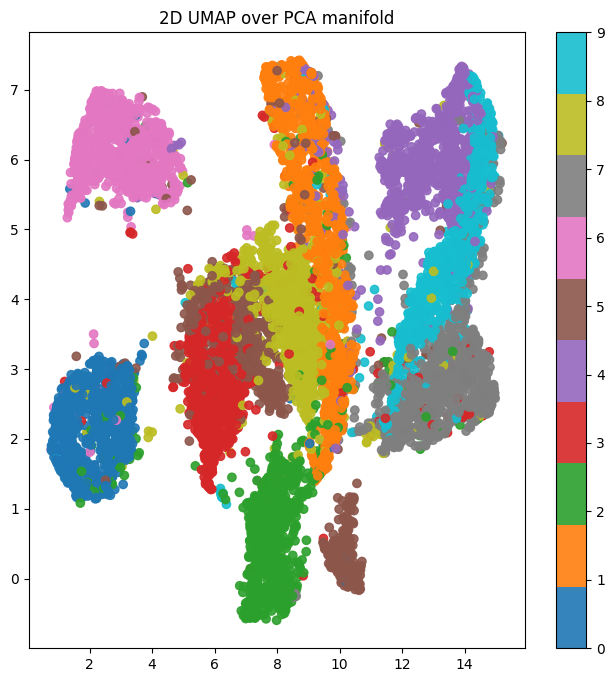

In [16]:
import umap
from sklearn.preprocessing import StandardScaler

scaled_latent_r = StandardScaler().fit_transform(latent_r)
reducer = umap.UMAP()
latent_r_2d = reducer.fit_transform(scaled_latent_r)
plot_manifold(latent_r_2d, y_test, title="2D UMAP over PCA manifold")

В латентном представлении цифры в среднем неплохо разделяются на отдельные кластеры, но многие отдельные изображения оказываются в "чужих" кластерах. Для такого простого датасета результат неудовлетворительный.